In [29]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.io
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
mat_data = scipy.io.loadmat('/Users/elkysandor/Desktop/hujiyr3/geo of data/Data6.mat')
n = 50
p = 0.45
q = 0.05

# generate stochastic block model matrix
def random_mat(n,p,q):
    iu1 = np.triu_indices(n,1)
    W_AA = np.zeros((n,n))
    W_BA = np.zeros((n,n))
    W_BB = np.zeros((n,n))
    #W_CC = np.zeros((n,n))

    # set random binary edges for upper triangle of matrix
    W_AA[iu1]  = np.random.binomial(1,p,int(n*(n-1)/2))
    W_BB[iu1]  = np.random.binomial(1,p,int(n*(n-1)/2))
    W_BA = (np.random.binomial(1,q,size = (n,n)))/2
    W = np.concatenate((np.concatenate((W_AA,W_BA.T),axis = 1),np.concatenate((W_BA,W_BB),axis = 1)), axis = 0)
    

    # Graph is unweighted - make matrix symmetric
    W = W + W.T
    L = np.diag(np.sum(W,axis = 1))-W

    # compute eigenvalues and eigenvectors of Laplacian
    [D,V] = np.linalg.eigh(L)

    #show matrix, Fiedler vector and eigenvalues
    fig,ax = plt.subplots(1,4,figsize = (15,5))
    ax = ax.flat
    for i in range(3):
        ax[i].plot(V[:,i])
        ax[i].set_title(f"the {i+1} leading eigenvec")
#     ax[0].imshow(W)
#     ax[1].plot(V[:,1])
    ax[3].plot(np.abs(D[0:3]),'bo')
    fig.suptitle(f" p ={p} and q = {q}")
    plt.show()
#     a = 1
#     plt.set_title
                        
    

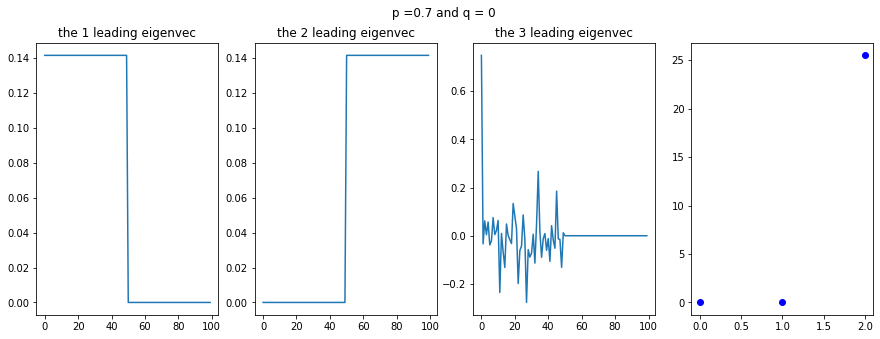

In [30]:
random_mat(50,0.7,0)

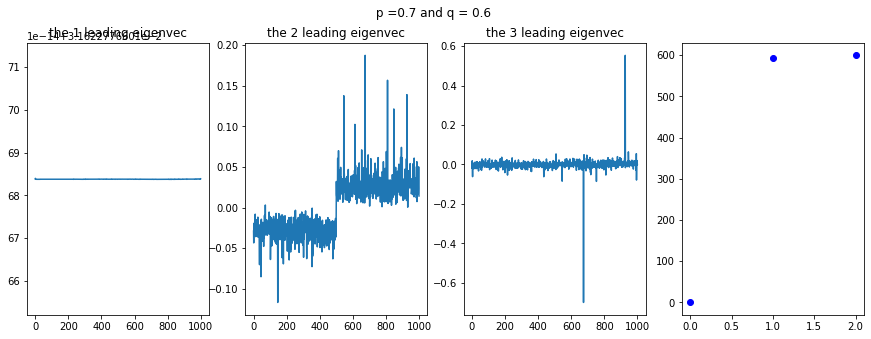

In [31]:
random_mat(500,0.7,0.6)

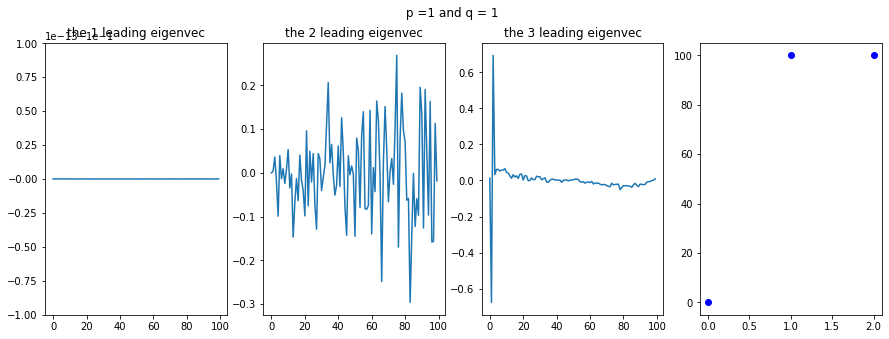

In [32]:
random_mat(50,1,1)

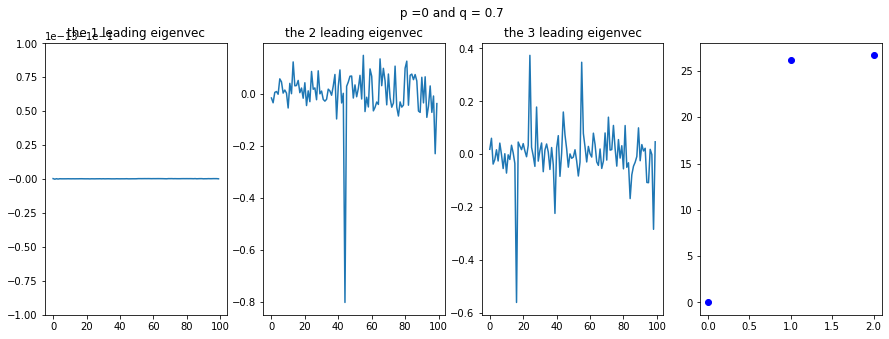

In [33]:
random_mat(50,0,0.7)

In [34]:
mat_data["XX"][0][1].shape

(303, 2)

<function matplotlib.pyplot.show(close=None, block=None)>

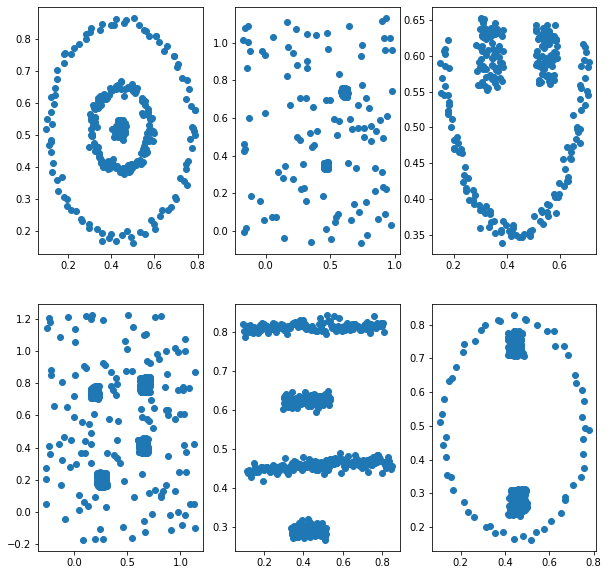

In [35]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(10,10))
axes = axes.flat
for i in range(len(mat_data["XX"][0])):
    axes[i].scatter(mat_data["XX"][0][i][:,0],mat_data["XX"][0][i][:,1])
plt.show    

In [36]:
circles = mat_data["XX"][0][0]
smiley = mat_data["XX"][0][2]


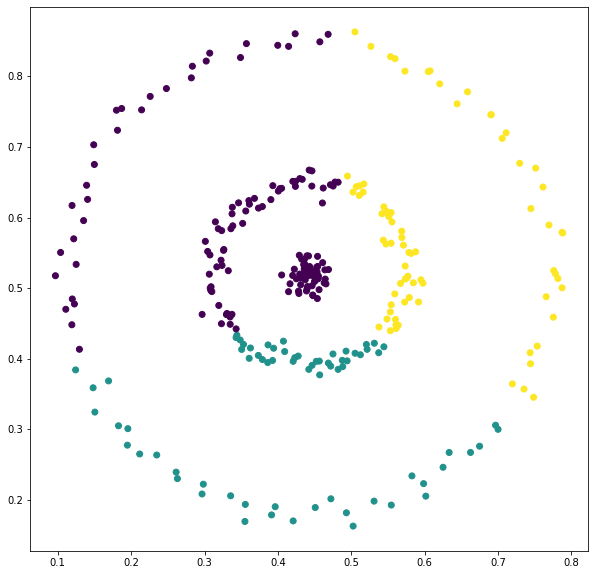

In [37]:
def k_means(data,k):
    beg_kmeans = KMeans(n_clusters=k,random_state=0).fit(data)
    kmeans = beg_kmeans.transform(data)
    idx = beg_kmeans.predict(data)
    return kmeans,idx
check = k_means(circles,3)
plt.figure(figsize=(10,10))
plt.scatter(circles[:,0],circles[:,1],c = check[1])

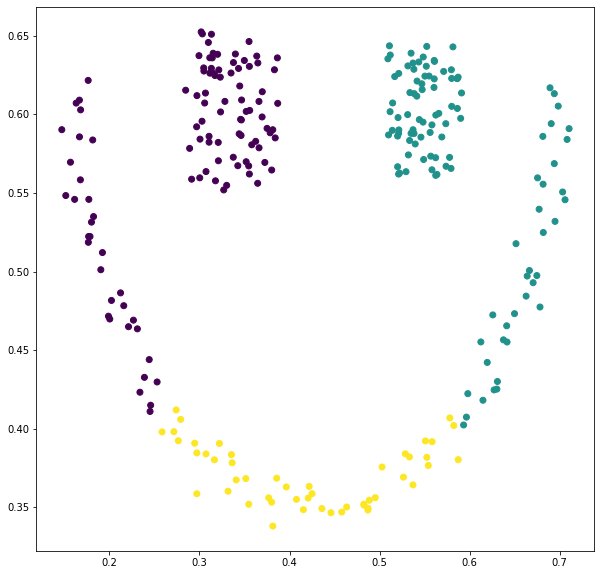

In [38]:
check_2 = k_means(smiley,3)
plt.figure(figsize=(10,10))
plt.scatter(smiley[:,0],smiley[:,1],c = check_2[1])

In [39]:
def create_adj_mat(data,sigma):
    w_mat = rbf_kernel(data,gamma = (1/sigma))
    laplacian = np.diag(np.sum(w_mat,axis = 1))-w_mat
    return(laplacian)
circles.shape



(299, 2)

Text(0.5, 1.0, 'with sigma = 0.001')

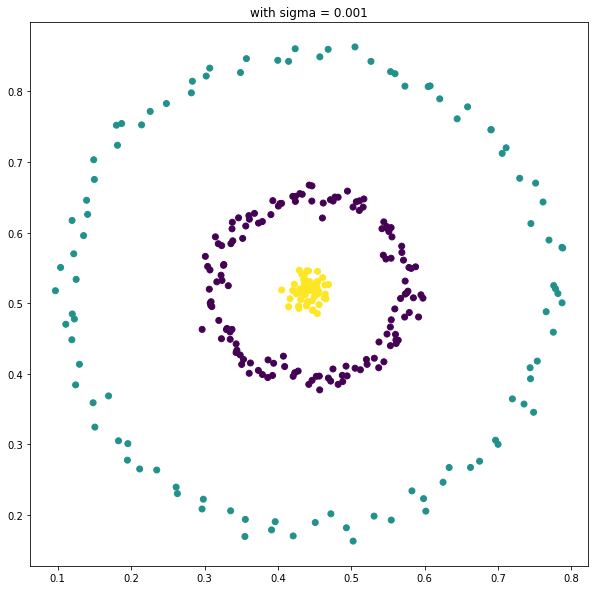

In [40]:
def spectral_cluster(data,sigma,k):
    laplacian = create_adj_mat(data,sigma)
    eigen_val,eigen_vec = np.linalg.eig(laplacian)
    idx = eigen_val.argsort()
    eigen_vec = eigen_vec[:,idx]
    k_leading_vecs = eigen_vec[:,:k]
    spc_cs,spc_idx = k_means(k_leading_vecs,k)
    return spc_cs,spc_idx
    
spc_cs = spectral_cluster(circles,sigma=0.001,k=3)
plt.figure(figsize=(10,10))
plt.scatter(circles[:,0],circles[:,1],c = spc_cs[1])
plt.title(f"with sigma = {0.001}") 




Text(0.5, 1.0, 'with sigma = 0.001')

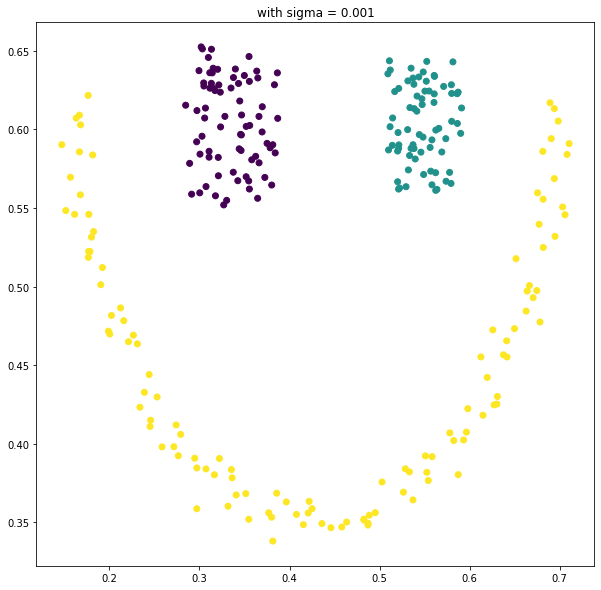

In [41]:
spc_cs_2 = spectral_cluster(smiley,sigma=0.001,k=3)
plt.figure(figsize=(10,10))
plt.scatter(smiley[:,0],smiley[:,1],c = spc_cs_2[1])
plt.title(f"with sigma = {0.001}") 

In [42]:
def local_sigma(data,m):
    mnearest = NearestNeighbors(n_neighbors=m)
    mnearest.fit(data)
    local_sigmas = mnearest.kneighbors(data)[0][:,m-1]
    return local_sigmas

In [43]:
def build_W(data,m):
    n= data.shape[0]
    W_mat = np.zeros((n,n))
    sigmas = local_sigma(data,m)
    for i in range(n):
        for j in range(n):
            norm_sq = np.linalg.norm((data[i]-data[j]))**2
            sigma_ij = sigmas[i]*sigmas[j]
            final = np.exp(-(norm_sq/sigma_ij))
            W_mat[i,j] = final
    return W_mat

In [44]:
def self_tunning_cs(data,m,k):
    w_mat = build_W(data,m)
    laplacian = np.diag(np.sum(w_mat,axis = 1))-w_mat
    eigen_val,eigen_vec = np.linalg.eig(laplacian)
    idx = eigen_val.argsort()
    eigen_vec = eigen_vec[:,idx]
    k_leading_vecs = eigen_vec[:,:k]
    spc_cs,spc_idx = k_means(k_leading_vecs,k)
    return spc_cs,spc_idx

Text(0.5, 1.0, 'self tuning spectral clustering')

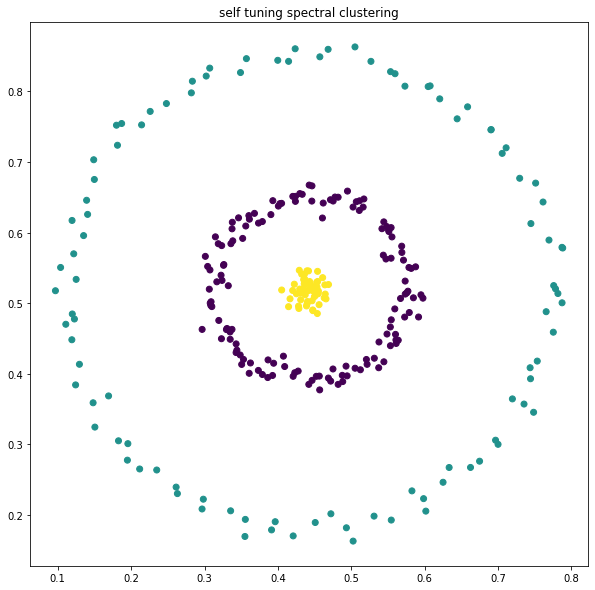

In [45]:
self_cs = self_tunning_cs(circles,7,3)
plt.figure(figsize=(10,10))
plt.scatter(circles[:,0],circles[:,1],c = self_cs[1])
plt.title("self tuning spectral clustering")

Text(0.5, 1.0, 'self tuning spectral clustering')

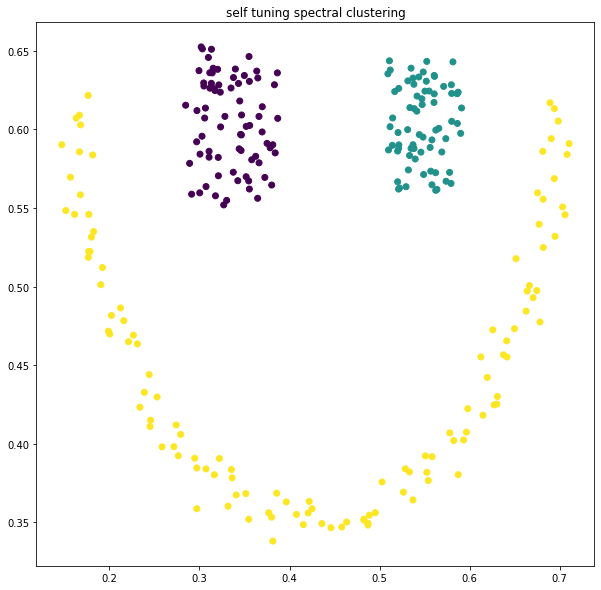

In [46]:
self_cs_2 = spectral_cluster(smiley,sigma=0.002,k=3)
plt.figure(figsize=(10,10))
plt.scatter(smiley[:,0],smiley[:,1],c = self_cs_2[1])
plt.title("self tuning spectral clustering")